# Recipe Multimodal Preprocessing Pipeline

This notebook cleans and prepares the **Food Ingredients and Recipe** dataset + images
for use with **Graph RAG**, **CM RAG**, and **multimodal LLMs**.

It assumes this notebook is placed in the **same folder** as:
- `Food Ingredients and Recipe Dataset with Image Name Mapping.csv`
- `Food Images/` (folder containing images)

Outputs:
- `cleaned_recipes.csv`
- `recipes_for_rag.jsonl`
- `recipes_for_rag_chunked.jsonl`
- `ingredients_nodes.jsonl`, `recipes_nodes.jsonl`, `edges_ingredient_recipe.jsonl` (for Graph RAG)


In [35]:
import ast
import json
import re
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# Root = current working directory (place this notebook in the dataset folder)
ROOT = Path.cwd()
CSV_PATH = ROOT / 'Food Ingredients and Recipe Dataset with Image Name Mapping.csv'
IMAGES_DIR = ROOT / 'Food Images' / 'Food Images'


print('ROOT:', ROOT)
print('CSV exists?', CSV_PATH.exists())
print('IMAGES_DIR exists?', IMAGES_DIR.exists())

df = pd.read_csv(CSV_PATH)
print('Loaded rows:', len(df))
df.head()


ROOT: c:\Users\saipa\OneDrive\Documentos\LLM\ProjectRecipe\archive
CSV exists? True
IMAGES_DIR exists? True
Loaded rows: 13501


,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [36]:
# Basic info
display(df.head())
display(df.describe(include='all'))
print('\nNull values per column:')
print(df.isna().sum())

# Drop exact duplicates on title + instructions
before = len(df)
df = df.drop_duplicates(subset=['Title', 'Instructions']).reset_index(drop=True)
print(f'Dropped {before - len(df)} duplicate rows')


,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
count,13501.000000,13496,13501,13493,13501,13501
unique,NaN,13305,13473,13464,13472,13473
top,NaN,French 75,[],Place ingredients in blender in the order list...,#NAME?,['']
freq,NaN,5,12,5,30,12
mean,6750.000000,NaN,NaN,NaN,NaN,NaN
std,3897.547327,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN
25%,3375.000000,NaN,NaN,NaN,NaN,NaN
50%,6750.000000,NaN,NaN,NaN,NaN,NaN
75%,10125.000000,NaN,NaN,NaN,NaN,NaN



Null values per column:
Unnamed: 0             0
Title                  5
Ingredients            0
Instructions           8
Image_Name             0
Cleaned_Ingredients    0
dtype: int64
Dropped 17 duplicate rows


In [37]:
# Ensure ingredient columns are Python lists, not strings
def parse_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

df['Ingredients_raw_list'] = df['Ingredients'].apply(parse_list)
if 'Cleaned_Ingredients' in df.columns:
    df['Cleaned_Ingredients_raw'] = df['Cleaned_Ingredients'].apply(parse_list)
else:
    df['Cleaned_Ingredients_raw'] = df['Ingredients_raw_list']

df[['Title', 'Ingredients_raw_list']].head()


,Title,Ingredients_raw_list
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"[1 (3½–4-lb.) whole chicken, 2¾ tsp. kosher sa..."
1,Crispy Salt and Pepper Potatoes,"[2 large egg whites, 1 pound new potatoes (abo..."
2,Thanksgiving Mac and Cheese,"[1 cup evaporated milk, 1 cup whole milk, 1 ts..."
3,Italian Sausage and Bread Stuffing,"[1 (¾- to 1-pound) round Italian loaf, cut int..."
4,Newton's Law,"[1 teaspoon dark brown sugar, 1 teaspoon hot w..."


In [38]:
# Generic text cleaning helpers
def clean_text_basic(s: str) -> str:
    if not isinstance(s, str):
        s = '' if s is None else str(s)
    # remove HTML tags
    s = re.sub(r'<.*?>', ' ', s)
    # normalize unicode to ASCII-ish
    s = re.sub(r'[^\x00-\x7F]+', ' ', s)
    # collapse repeated whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def normalize_unicode_fractions(s: str) -> str:
    if not isinstance(s, str):
        s = '' if s is None else str(s)
    # replace common unicode fractions
    s = s.replace('½', '1/2').replace('¼', '1/4').replace('¾', '3/4')
    s = s.replace('–', '-')  # en-dash to hyphen
    return s

def clean_title(t: str) -> str:
    t = normalize_unicode_fractions(str(t))
    t = clean_text_basic(t)
    return t

df['Title_clean'] = df['Title'].apply(clean_title)
df[['Title', 'Title_clean']].head()


,Title,Title_clean
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,Miso-Butter Roast Chicken With Acorn Squash Pa...
1,Crispy Salt and Pepper Potatoes,Crispy Salt and Pepper Potatoes
2,Thanksgiving Mac and Cheese,Thanksgiving Mac and Cheese
3,Italian Sausage and Bread Stuffing,Italian Sausage and Bread Stuffing
4,Newton's Law,Newton's Law


In [39]:
# Clean and normalize instructions
def clean_instructions(instr: str) -> str:
    if not isinstance(instr, str):
        instr = '' if instr is None else str(instr)
    instr = normalize_unicode_fractions(instr)
    instr = clean_text_basic(instr)
    # split sentences into pseudo-steps by period
    instr = re.sub(r'\.\s+', '.\n', instr)
    instr = re.sub(r'\n+', '\n', instr)
    return instr.strip()

df['Instructions_clean'] = df['Instructions'].fillna('').apply(clean_instructions)

df['instruction_len_chars'] = df['Instructions_clean'].apply(len)
df['instruction_len_words'] = df['Instructions_clean'].apply(lambda s: len(s.split()))
df['num_steps'] = df['Instructions_clean'].apply(
    lambda s: max(1, len([p for p in s.split('\n') if p.strip()]))
)

df[['Instructions_clean', 'instruction_len_words', 'num_steps']].head()


,Instructions_clean,instruction_len_words,num_steps
0,"Pat chicken dry with paper towels, season all ...",444,35
1,Preheat oven to 400 F and line a rimmed baking...,114,6
2,Place a rack in middle of oven; preheat to 400...,150,14
3,Preheat oven to 350 F with rack in middle.\nGe...,285,18
4,Stir together brown sugar and hot water in a c...,46,5


In [40]:
# Ingredient cleaning
MEASURE_WORDS = {
    'cup','cups','teaspoon','teaspoons','tablespoon','tablespoons','tbsp','tsp',
    'pound','pounds','lb','lbs','ounce','ounces','oz','gram','grams','g','kg',
    'ml','l','liter','liters','slice','slices','can','cans','package','packages',
    'stick','sticks'
}

COOKING_WORDS = {
    'chopped','finely','coarsely','fresh','large','small','medium','ground','grated',
    'minced','diced','sliced','crushed','kosher','into','or','and'
}

def clean_ingredient_item(item: str) -> str:
    item = normalize_unicode_fractions(str(item))
    item = clean_text_basic(item)
    return item

def process_ingredient_list(lst):
    if not isinstance(lst, list):
        return [], []
    cleaned_list = []
    core_tokens = []
    for item in lst:
        c = clean_ingredient_item(item)
        cleaned_list.append(c)
        # build core tokens version (no numbers/units)
        tmp = re.sub(r"[^\w\s']", ' ', c.lower())
        toks = [t.strip() for t in tmp.split() if t.strip()]
        for t in toks:
            if t.isdigit() or any(ch.isdigit() for ch in t):
                continue
            if t in MEASURE_WORDS or t in COOKING_WORDS:
                continue
            core_tokens.append(t)
    return cleaned_list, sorted(set(core_tokens))

df['Ingredients_clean_list'], df['ingredient_core_tokens'] = zip(
    *df['Ingredients_raw_list'].apply(process_ingredient_list)
)

df['ingredient_count'] = df['Ingredients_clean_list'].apply(lambda x: len(x))
df['unique_ingredient_tokens'] = df['ingredient_core_tokens'].apply(len)

df[['Ingredients_clean_list', 'ingredient_core_tokens']].head()


,Ingredients_clean_list,ingredient_core_tokens
0,"[1 (31/2-4-lb.) whole chicken, 23/4 tsp. koshe...","[about, acorn, all, allspice, apple, apples, a..."
1,"[2 large egg whites, 1 pound new potatoes (abo...","[about, black, diameter, egg, in, inch, new, p..."
2,"[1 cup evaporated milk, 1 cup whole milk, 1 ts...","[black, cheddar, cheese, cream, elbow, evapora..."
3,"[1 (3/4- to 1-pound) round Italian loaf, cut i...","[baking, beaten, broth, butter, casings, celer..."
4,"[1 teaspoon dark brown sugar, 1 teaspoon hot w...","[apple, bourbon, brown, butter, cinnamon, dark..."


In [41]:
# ============================================================
# IMAGE VALIDATION (Correct + Fast + Handles Leading Dash "-")
# ============================================================

from pathlib import Path
import os

# 1) Make sure IMAGES_DIR points to the REAL directory
#    (your folder structure has Food Images/Food Images/)
IMAGES_DIR = ROOT / "Food Images" / "Food Images"

print("IMAGES_DIR =", IMAGES_DIR)
print("Sample files:", sorted(os.listdir(IMAGES_DIR))[:10])

# 2) Build a normalized filename → path map
file_map = {}

for fname in os.listdir(IMAGES_DIR):
    p = IMAGES_DIR / fname
    if not p.is_file():
        continue
    
    # remove extension, strip leading hyphens
    stem = p.stem  # e.g., "-fried-chicken-51238060"
    norm = stem.lstrip("-").lower().strip()
    
    file_map[norm] = p

print("Example mappings (first 5):")
print(list(file_map.items())[:5])

# 3) Normalize CSV names to match
def normalize_image_name(name: str) -> str:
    name = str(name).strip().lower()
    if "." in name:                 # remove extension if any exists
        name = name.split(".")[0]
    return name

df["Image_Name_norm"] = df["Image_Name"].apply(normalize_image_name)

# 4) Map to actual image paths
df["Image_Path"] = df["Image_Name_norm"].map(file_map)
df["image_exists"] = df["Image_Path"].notna()

# Summary count
missing = df["Image_Path"].isna().sum()
total = len(df)
print(f"Total rows: {total}")
print(f"Matched images: {total - missing}")
print(f"Missing images: {missing}")

# 5) Remove rows without images (multimodal requirement)
before = len(df)
df = df[df["image_exists"]].reset_index(drop=True)
print("Dropped rows without images:", before - len(df))
print("Remaining rows:", len(df))


IMAGES_DIR = c:\Users\saipa\OneDrive\Documentos\LLM\ProjectRecipe\archive\Food Images\Food Images
Sample files: ['-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813.jpg', '-burnt-carrots-and-parsnips-56390131.jpg', '-candy-corn-frozen-citrus-cream-pops-368770.jpg', '-candy-corn-pumpkin-blondies-51254510.jpg', '-carbonnade-a-la-flamande-short-ribs-358557.jpg', '-chickpea-barley-and-feta-salad-51239040.jpg', '-chickpea-pancakes-with-leeks-squash-and-yogurt-51260630.jpg', '-cod-with-mussels-chorizo-fried-croutons-and-saffron-mayonnaise-355204.jpg', '-em-ba-em-s-ultimate-lobster-rolls-51169080.jpg', '-em-gourmet-live-em-s-first-birthday-cake-367789.jpg']
Example mappings (first 5):
[('bloody-mary-tomato-toast-with-celery-and-horseradish-56389813', WindowsPath('c:/Users/saipa/OneDrive/Documentos/LLM/ProjectRecipe/archive/Food Images/Food Images/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813.jpg')), ('burnt-carrots-and-parsnips-56390131', WindowsPath('c:/Users/sai

In [42]:
# Outlier removal based on simple heuristic thresholds
print('Before outlier filtering:', len(df))

# Remove recipes with no ingredients or no instructions
df = df[df['ingredient_count'] > 0]
df = df[df['Instructions_clean'].str.len() > 0]

# Heuristic thresholds
df = df[df['ingredient_count'] <= 40]
df = df[df['instruction_len_words'] <= 1500]
df = df[df['num_steps'] <= 60]

print('After outlier filtering:', len(df))


Before outlier filtering: 13454
After outlier filtering: 13415


In [43]:
# Build RAG document text (Title + Ingredients + Instructions)
def build_rag_text(row):
    title = row.get('Title_clean', '')
    ing_list = row.get('Ingredients_clean_list', [])
    instr = row.get('Instructions_clean', '')
    ingredients_block = '\n'.join(f'- {i}' for i in ing_list)
    doc = f"Title: {title}\n\nIngredients:\n{ingredients_block}\n\nInstructions:\n{instr}"
    return doc.strip()

df['rag_document_text'] = df.apply(build_rag_text, axis=1)
df[['Title_clean', 'rag_document_text']].head()


,Title_clean,rag_document_text
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,Title: Miso-Butter Roast Chicken With Acorn Sq...
1,Crispy Salt and Pepper Potatoes,Title: Crispy Salt and Pepper Potatoes\n\nIngr...
2,Thanksgiving Mac and Cheese,Title: Thanksgiving Mac and Cheese\n\nIngredie...
3,Italian Sausage and Bread Stuffing,Title: Italian Sausage and Bread Stuffing\n\nI...
4,Newton's Law,Title: Newton's Law\n\nIngredients:\n- 1 teasp...


In [44]:
# Save cleaned dataset
CLEANED_CSV = ROOT / 'cleaned_recipes.csv'
df.to_csv(CLEANED_CSV, index=False)
print('Saved cleaned CSV to', CLEANED_CSV)


Saved cleaned CSV to c:\Users\saipa\OneDrive\Documentos\LLM\ProjectRecipe\archive\cleaned_recipes.csv


In [45]:
# Create JSONL for RAG (one doc per recipe)
RAG_JSONL = ROOT / 'recipes_for_rag.jsonl'
with RAG_JSONL.open('w', encoding='utf-8') as f:
    for idx, row in df.iterrows():
        rec = {
            'id': str(idx),
            'text': row['rag_document_text'],
            'metadata': {
                'title': row['Title_clean'],
                'image_path': str(row['Image_Path']),
                'ingredient_core_tokens': row['ingredient_core_tokens'],
                'ingredient_count': int(row['ingredient_count']),
                'num_steps': int(row['num_steps'])
            }
        }
        f.write(json.dumps(rec, ensure_ascii=False) + '\n')

print('Saved RAG JSONL to', RAG_JSONL)


Saved RAG JSONL to c:\Users\saipa\OneDrive\Documentos\LLM\ProjectRecipe\archive\recipes_for_rag.jsonl


In [46]:
# Chunking helper and chunked JSONL
def chunk_text(text, max_words=350):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunk = ' '.join(words[i:i+max_words])
        if chunk.strip():
            chunks.append(chunk)
    return chunks

RAG_CHUNKED_JSONL = ROOT / 'recipes_for_rag_chunked.jsonl'
with RAG_CHUNKED_JSONL.open('w', encoding='utf-8') as f:
    for idx, row in df.iterrows():
        chunks = chunk_text(row['rag_document_text'], max_words=350)
        for j, ch in enumerate(chunks):
            rec = {
                'id': f"{idx}_{j}",
                'text': ch,
                'metadata': {
                    'recipe_id': str(idx),
                    'chunk_index': j,
                    'title': row['Title_clean'],
                    'image_path': str(row['Image_Path'])
                }
            }
            f.write(json.dumps(rec, ensure_ascii=False) + '\n')

print('Saved chunked RAG JSONL to', RAG_CHUNKED_JSONL)


Saved chunked RAG JSONL to c:\Users\saipa\OneDrive\Documentos\LLM\ProjectRecipe\archive\recipes_for_rag_chunked.jsonl


In [47]:
# Simple Graph RAG node/edge export
ING_NODES = ROOT / 'ingredients_nodes.jsonl'
REC_NODES = ROOT / 'recipes_nodes.jsonl'
EDGE_ING_REC = ROOT / 'edges_ingredient_recipe.jsonl'

ingredient_global_ids = {}

with ING_NODES.open('w', encoding='utf-8') as f_ing, \
     REC_NODES.open('w', encoding='utf-8') as f_rec, \
     EDGE_ING_REC.open('w', encoding='utf-8') as f_edge:

    # recipe nodes
    for idx, row in df.iterrows():
        rid = f'recipe_{idx}'
        rec_node = {
            'id': rid,
            'type': 'recipe',
            'title': row['Title_clean'],
            'ingredient_count': int(row['ingredient_count']),
            'num_steps': int(row['num_steps'])
        }
        f_rec.write(json.dumps(rec_node, ensure_ascii=False) + '\n')

        for token in row['ingredient_core_tokens']:
            if token not in ingredient_global_ids:
                ing_id = f'ingredient_{len(ingredient_global_ids)}'
                ingredient_global_ids[token] = ing_id
                ing_node = {
                    'id': ing_id,
                    'type': 'ingredient',
                    'name': token
                }
                f_ing.write(json.dumps(ing_node, ensure_ascii=False) + '\n')

            edge = {
                'source': ingredient_global_ids[token],
                'target': rid,
                'type': 'ingredient_in_recipe'
            }
            f_edge.write(json.dumps(edge, ensure_ascii=False) + '\n')

print('Graph files written:')
print(' -', ING_NODES)
print(' -', REC_NODES)
print(' -', EDGE_ING_REC)


Graph files written:
 - c:\Users\saipa\OneDrive\Documentos\LLM\ProjectRecipe\archive\ingredients_nodes.jsonl
 - c:\Users\saipa\OneDrive\Documentos\LLM\ProjectRecipe\archive\recipes_nodes.jsonl
 - c:\Users\saipa\OneDrive\Documentos\LLM\ProjectRecipe\archive\edges_ingredient_recipe.jsonl


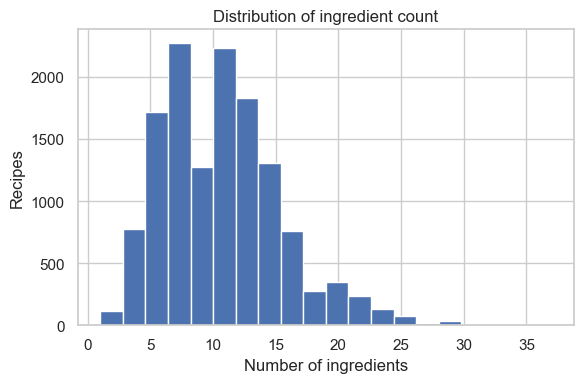

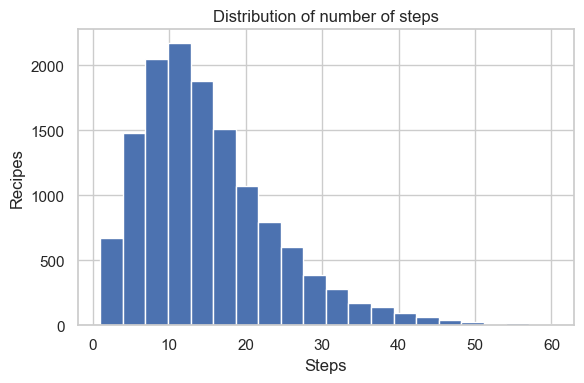

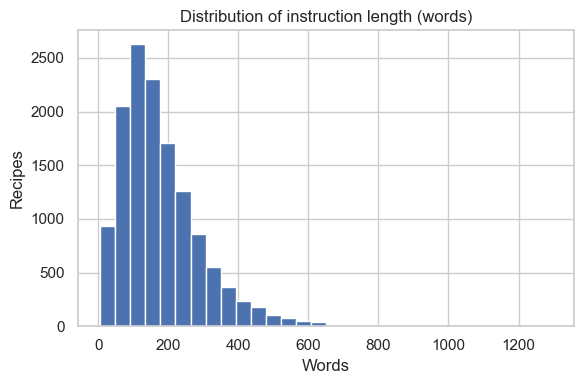

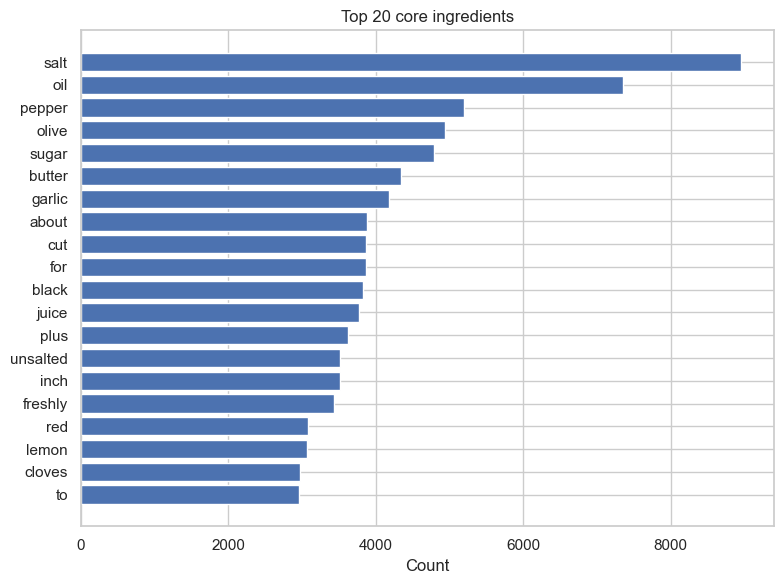

In [48]:
# EDA: ingredient count, steps, instruction length, top ingredients
plt.figure(figsize=(6,4))
plt.hist(df['ingredient_count'], bins=20)
plt.title('Distribution of ingredient count')
plt.xlabel('Number of ingredients')
plt.ylabel('Recipes')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['num_steps'], bins=20)
plt.title('Distribution of number of steps')
plt.xlabel('Steps')
plt.ylabel('Recipes')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['instruction_len_words'], bins=30)
plt.title('Distribution of instruction length (words)')
plt.xlabel('Words')
plt.ylabel('Recipes')
plt.tight_layout()
plt.show()

# Top ingredients by core token frequency
all_tokens = Counter(
    t for toks in df['ingredient_core_tokens'] for t in toks
)
top_ing = all_tokens.most_common(20)
if top_ing:
    labels, counts = zip(*top_ing)
else:
    labels, counts = [], []

plt.figure(figsize=(8,6))
plt.barh(labels, counts)
plt.title('Top 20 core ingredients')
plt.xlabel('Count')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()
